# NER задача

In [1]:
# Импорт библиотек
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import gensim.downloader as api

import numpy as np
import pandas as pd

# Выбираем видеокарту
device = 'cuda' if torch.cuda.is_available() else 'gpu'
device

'cuda'

# Обзор датасета

In [2]:
w2v_model = api.load("glove-twitter-25")
conll2003 = load_dataset('conll2003')
conll2003

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [3]:
# Посмотрим на пример данных находящихся в обучающем датасете
example = conll2003['train'][50]
# example = conll2003['train'][1]

print(f'Пример имеет тип - {type(example)}')
print(f'И состоит из следующих ключей - {example.keys()}')
print('\nЧто же находится в каждом из элементов словаря')

print('\n"tokens" - исходные токены, для которых была сделана NER-разметка')
print(f'\nПредложение - {(" ").join(example["tokens"])}')
print(f'Токены - {example["tokens"]}')

print('\n\n"ner_tags" - векторизированные метки NER-тэгов')
print(f'Метки NER-тэгов - {example["ner_tags"]}')

print('\n"pos_tags" - разметка частей речи, которую мы будем игнорировать')
print(f'Части речи - {example["pos_tags"]}')

print('\n"chunk_tags" - Разметка чанков, которую мы будем игнорировать')
print(f'Чанки - {example["chunk_tags"]}')

Пример имеет тип - <class 'dict'>
И состоит из следующих ключей - dict_keys(['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'])

Что же находится в каждом из элементов словаря

"tokens" - исходные токены, для которых была сделана NER-разметка

Предложение - Opel AG together with General Motors came in second place with 49,269 registrations , 16.4 percent of the overall figure .
Токены - ['Opel', 'AG', 'together', 'with', 'General', 'Motors', 'came', 'in', 'second', 'place', 'with', '49,269', 'registrations', ',', '16.4', 'percent', 'of', 'the', 'overall', 'figure', '.']


"ner_tags" - векторизированные метки NER-тэгов
Метки NER-тэгов - [3, 4, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

"pos_tags" - разметка частей речи, которую мы будем игнорировать
Части речи - [22, 22, 30, 15, 22, 23, 38, 15, 16, 21, 15, 11, 24, 6, 11, 21, 15, 12, 16, 21, 7]

"chunk_tags" - Разметка чанков, которую мы будем игнорировать
Чанки - [11, 12, 3, 13, 11, 12, 21, 13, 11, 12, 13, 11, 12, 0, 

Рассмотрим, как работают метки в задаче NER. В данной задаче у нас есть 4 типа именованных сущностей:

*   **PER** - персона
*   **ORG** - организация
*   **LOC** - локация
*   **MISC** - другое
*   **O** - отсутствие именованной сущности

У каждого типа есть 2 префикса

*   **B-** - begining, начало именованной сущности
*   **I-** - inside, продолжение ранее начатой именнованной сущности


Прекрасно, теперь попробуем преобразовать метки в тензоры.

In [4]:
# Существующие теги
print('Теги в train - ', conll2003["train"].features["ner_tags"].feature)
print('Теги в validation - ', conll2003["validation"].features["ner_tags"].feature)
print('Теги в test - ', conll2003["test"].features["ner_tags"].feature)

Теги в train -  ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None)
Теги в validation -  ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None)
Теги в test -  ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None)


In [5]:
# Преобразование меток в тензоры и создание словаря
def tokenize_and_encode(data, word_to_idx, tag_to_idx):
    """Преобразует токены и соответствующие им теги в индексы.

    Args:
        - data (dict): Словарь с данными, в нашем случае нам понадобятся ключи 'tokens' и 'ner_tags'
        - word_to_idx (dict): Словарь, где ключи - это токены (строки), а значения - их индексы (целые числа) \n
        В случае отсутствия токена в словаре используется индекс для 'UNK'.
        - tag_to_idx (dict): Словарь, где ключи - это теги (целые числа), а значения - их индексы (целые числа)

    Returns:
        Возвращаем два тензора:
        - torch.Tensor: Индексы токенов
        - torch.Tensor: Индексы тегов
    """
    token_idx = [word_to_idx.get(token, word_to_idx['<UNK>']) for token in data['tokens']]
    tag_idx = [tag_to_idx[tag] for tag in data['ner_tags']] 
    return torch.tensor(token_idx), torch.tensor(tag_idx)

# Создаём словари для токенов и меток
all_tokens = set(token for example in conll2003['train'] for token in example['tokens'])
all_tags = set(tag for example in conll2003['train'] for tag in example['ner_tags'])

# Резервируем первые два индекса для токенов <PAD> и <UNK>
word_to_idx = {word: idx + 2 for idx, word in enumerate(all_tokens)}
word_to_idx['<PAD>'] = 0
word_to_idx['<UNK>'] = 1

# Сопоставляем тегу его индекс
# тк изначально у нас числовое представление тегов 
tag_to_idx = {tag: idx for idx, tag in enumerate(all_tags)}
# Пересобираем в обратном направлении
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

In [6]:
# Токены и метки в валидации/тесте
val_tokens = set(token for example in conll2003['validation'] for token in example['tokens'])
val_tags = set(tag for example in conll2003['validation'] for tag in example['ner_tags'])

# Проверка отсутствующих токенов и меток
missing_tokens = val_tokens - all_tokens
missing_tags = val_tags - all_tags

print("Отсутствующие токены в валидационном наборе:", len(missing_tokens))
print("Отсутствующие метки в валидационном наборе:", len(missing_tags))

Отсутствующие токены в валидационном наборе: 3260
Отсутствующие метки в валидационном наборе: 0


In [7]:
# Наследуемся от класса датасета чтобы сохранить совместимость
class NERDataset(Dataset):
    def __init__(self, data, word_to_idx, tag_to_idx):
        self.data = data
        self.word_to_idx = word_to_idx
        self.tag_to_idx = tag_to_idx
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        tokens, tags = tokenize_and_encode(self.data[index], self.word_to_idx, self.tag_to_idx)
        return tokens, tags

# Функция для паддинга последовательностей
def collate_fn(batch):
    tokens, tags = zip(*batch)
    tokens_padded = pad_sequence(tokens, batch_first=True, padding_value=word_to_idx['<PAD>'])
    # ставим метки -100 которые игнорируются функцией потерь 
    tag_padded = pad_sequence(tags, batch_first=True, padding_value=-100)
    return tokens_padded, tag_padded

# Создаём DataLoader
train_dataset = NERDataset(conll2003['train'], word_to_idx, tag_to_idx)
val_dataset = NERDataset(conll2003['validation'], word_to_idx, tag_to_idx)
test_dataset = NERDataset(conll2003['test'], word_to_idx, tag_to_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)


# Создание модели

In [8]:
# Создаём классификатор NER с помощью RNN
class NERModel_RNN(nn.Module):
    def __init__(self, vocab_size, target_size, embedding_dim=128, hidden_dim=64, bidirectional=True):
        super(NERModel_RNN, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_dim,
                                      padding_idx=word_to_idx['<PAD>'])
        if bidirectional:
            self.rnn = nn.RNN(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            batch_first=True,
                            bidirectional=True)
            self.fc = nn.Linear(hidden_dim*2, target_size)
        else:
            self.rnn = nn.RNN(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            batch_first=True,
                            bidirectional=False)
            self.fc = nn.Linear(hidden_dim, target_size)
            
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x
    
        
# Создаём классификатор NER с помощью LSTM
class NERModel_LSTM(nn.Module):
    def __init__(self, vocab_size, target_size, embedding_dim=128, hidden_dim=64, bidirectional=True):
        super(NERModel_LSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_dim,
                                      padding_idx=word_to_idx['<PAD>'])
        if bidirectional:
            self.lstm = nn.LSTM(input_size=embedding_dim,
                               hidden_size=hidden_dim,
                               batch_first=True,
                               bidirectional=True)
            self.fc = nn.Linear(hidden_dim*2, target_size)
        else:
            self.lstm = nn.LSTM(input_size=embedding_dim,
                               hidden_size=hidden_dim,
                               batch_first=True,
                               bidirectional=False)
            self.fc = nn.Linear(hidden_dim, target_size)
            
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x
    
# Инициализировали модели
model_rnn = NERModel_RNN(vocab_size=len(word_to_idx), target_size=len(tag_to_idx))
model_lstm = NERModel_LSTM(vocab_size=len(word_to_idx), target_size=len(tag_to_idx))
# model_rnn_bidir = NERModel_RNN(vocab_size=len(word_to_idx), target_size=len(tag_to_idx), bidirectional=True)
# model_lstm_bidir = NERModel_LSTM(vocab_size=len(word_to_idx), target_size=len(tag_to_idx), bidirectional=True)

model_rnn.to(device)
model_lstm.to(device)
# model_rnn_bidir.to(device)
# model_lstm_bidir.to(device)

# Выбрали оптимизатор
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
# optimizer_rnn_bidir = torch.optim.Adam(model_rnn_bidir.parameters(), lr=0.001)
# optimizer_lstm_bidir = torch.optim.Adam(model_lstm_bidir.parameters(), lr=0.001)

# Выбрали функцию потерь (игнорируем паддинг)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

In [9]:
def eval_model(model, data, criterion):
    # Устанавливаем модель в режим оценки
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for tokens, tags in data:
            # Переводим данные на устройство
            tokens = tokens.to(device)
            tags = tags.to(device)
            outputs = model(tokens)
            outputs = outputs.view(-1, outputs.shape[-1])
            tags = tags.view(-1)
            
            # Вычисляем потери
            loss = criterion(outputs, tags)
            total_loss += loss.item()
            
            # Получаем предсказанные метки
            _, preds = torch.max(outputs, dim=1)
            
            # Сохраняем предсказания и истинные метки, исключая паддинг
            mask = tags != 1
            all_preds.extend(preds[mask].cpu().numpy())
            all_labels.extend(tags[mask].cpu().numpy())
        
        avg_loss = total_loss / len(data)
        
        # zero_division=0 - обработчик для отсутствующего класса
        report = classification_report(all_labels, all_preds, zero_division=0)
        
        return avg_loss, report

def train_validate_model(model, train_data, val_data, optimizer, criterion, num_epochs=15):
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        # ставим модель в режим обучения
        model.train()
        total_loss = 0
        
        for tokens, tags in train_data:
            # Переводим данные на устройство
            tokens = tokens.to(device)  
            tags = tags.to(device)
            optimizer.zero_grad()
            
            outputs = model(tokens)
            # print('Размерность выхода модели до преобразования - ', outputs.shape)
            outputs = outputs.view(-1, outputs.shape[-1])
            # print('Размерность выхода модели после преобразования - ', outputs.shape)
            # print('Размерность тегов - ', tags.shape)
            tags = tags.view(-1)
            # print('Размерность тегов после изменения - ', tags.shape)

            loss = criterion(outputs, tags)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        train_loss = total_loss / len(train_data)
        print(f'Номер эпохи: {epoch+1}/{num_epochs}, Потери на обучении {train_loss:.2f}')
        
        # Оценка на валидационном наборе
        val_loss, val_rep = eval_model(model, val_data, criterion)
        print(f'Потери на валидации {val_loss:.2f}\n')
        
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        
    print(f'{val_rep}\n\n')     
    
    # Визуализация точности и потерь
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss', color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss over Epochs')
    plt.legend()

    plt.show()

def test_model(model, data, criterion):
    # Оценка на тестовом наборе
    test_loss, test_rep = eval_model(model, data, criterion)
    print(f'Ошибка на тестовом наборе {test_loss:.2f}\n')
    # print(f'Собранные метрики\n{test_rep}')

# Обучение / Тестирование модели

Обучение RNN модели

Номер эпохи: 1/10, Потери на обучении 0.58
Потери на валидации 0.41

Номер эпохи: 2/10, Потери на обучении 0.30
Потери на валидации 0.28

Номер эпохи: 3/10, Потери на обучении 0.19
Потери на валидации 0.27

Номер эпохи: 4/10, Потери на обучении 0.12
Потери на валидации 0.24

Номер эпохи: 5/10, Потери на обучении 0.08
Потери на валидации 0.29

Номер эпохи: 6/10, Потери на обучении 0.05
Потери на валидации 0.27

Номер эпохи: 7/10, Потери на обучении 0.04
Потери на валидации 0.31

Номер эпохи: 8/10, Потери на обучении 0.02
Потери на валидации 0.33

Номер эпохи: 9/10, Потери на обучении 0.01
Потери на валидации 0.38

Номер эпохи: 10/10, Потери на обучении 0.01
Потери на валидации 0.40

              precision    recall  f1-score   support

        -100       0.00      0.00      0.00     77014
           0       0.48      0.94      0.64     42759
           1       0.00      0.00      0.00         0
           2       0.66      0.91      0.76      1307
           3     

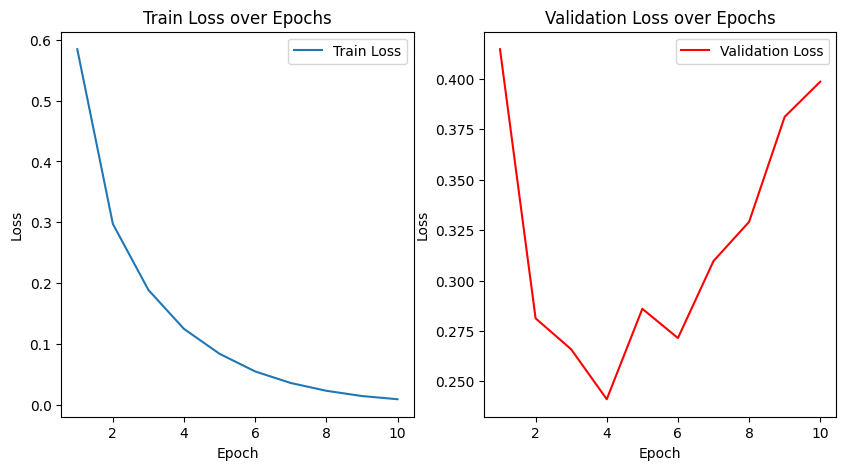

In [10]:
print('Обучение RNN модели\n')

# Обучаем модельку RNN
train_validate_model(model_rnn,
                     train_loader,
                     val_loader,
                     optimizer_rnn,
                     criterion,
                     num_epochs=10)

Обучение LSTM модели

Номер эпохи: 1/10, Потери на обучении 0.63
Потери на валидации 0.45

Номер эпохи: 2/10, Потери на обучении 0.30
Потери на валидации 0.28

Номер эпохи: 3/10, Потери на обучении 0.17
Потери на валидации 0.21

Номер эпохи: 4/10, Потери на обучении 0.10
Потери на валидации 0.18

Номер эпохи: 5/10, Потери на обучении 0.06
Потери на валидации 0.17

Номер эпохи: 6/10, Потери на обучении 0.03
Потери на валидации 0.16

Номер эпохи: 7/10, Потери на обучении 0.02
Потери на валидации 0.17

Номер эпохи: 8/10, Потери на обучении 0.01
Потери на валидации 0.17

Номер эпохи: 9/10, Потери на обучении 0.01
Потери на валидации 0.17

Номер эпохи: 10/10, Потери на обучении 0.00
Потери на валидации 0.18

              precision    recall  f1-score   support

        -100       0.00      0.00      0.00     77014
           0       0.36      0.99      0.52     42759
           1       0.00      0.00      0.00         0
           2       0.79      0.84      0.81      1307
           3    

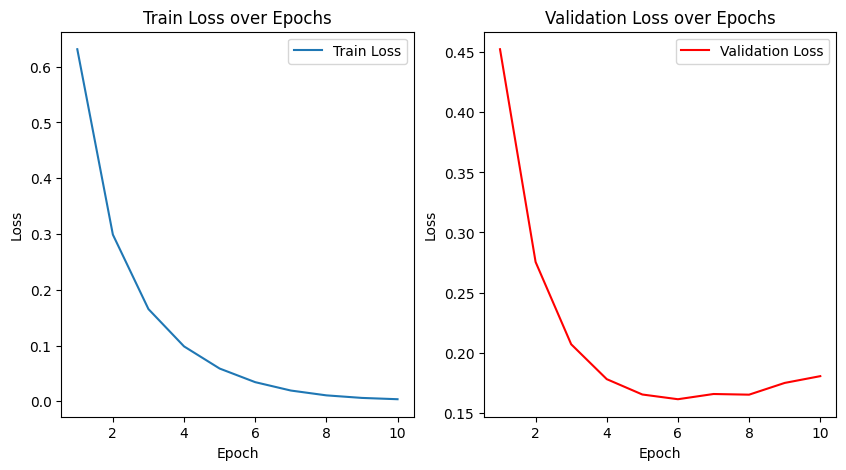

In [11]:
print('Обучение LSTM модели\n')
# Обучаем модельку LSTM
train_validate_model(model_lstm,
                     train_loader,
                     val_loader,
                     optimizer_lstm,
                     criterion,
                     num_epochs=10)

Мы видим, что обе модели переобучились

In [12]:
# Посмотрим какое качество мы можем получить на тестовых данных
print('Модель RNN:\n')
test_model(model_rnn.to(device),
           test_loader,
           criterion)

print('\n\nМодель LSTM:\n')
test_model(model_lstm.to(device),
           test_loader,
           criterion)

Модель RNN:

Ошибка на тестовом наборе 0.66



Модель LSTM:

Ошибка на тестовом наборе 0.33



In [13]:
# print('Обучение двунаправленной RNN модели\n')

# # Обучаем модельку RNN
# train_validate_model(model_rnn_bidir,
#                      train_loader,
#                      val_loader,
#                      optimizer_rnn_bidir,
#                      criterion,
#                      num_epochs=10)

In [14]:
# print('Обучение двунаправленной LSTM модели\n')

# # Обучаем модельку LSTM
# train_validate_model(model_lstm_bidir,
#                      train_loader,
#                      val_loader,
#                      optimizer_lstm_bidir,
#                      criterion,
#                      num_epochs=10)

# Смена эмбеддингов

Как мы видим модель плохо предсказывает метки тегов, попробуем сменить метод введения эмбеддингов

In [10]:
idx2label = ["O", "B-MISC", "I-MISC", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC"]
label2idx = {label: i for i, label in enumerate(idx2label)}

In [11]:
class NERModel_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, target_size, num_layers=2, bidirectional=True, dropout=0.3):
        super(NERModel_RNN, self).__init__()
        
        # Параметры модели
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        if bidirectional:
            # LSTM слой принимает входные данные размером input_size (размерность эмбеддингов)
            self.rnn = nn.LSTM(input_size=input_size,
                               hidden_size=hidden_size,
                               batch_first=True,
                               num_layers=num_layers,
                               bidirectional=True,
                               dropout=dropout)
            # Полносвязный слой для классификации
            self.fc = nn.Linear(hidden_size * 2, target_size)  # Умножаем на 2, так как bidirectional
        else:
            # LSTM слой принимает входные данные размером input_size (размерность эмбеддингов)
            self.rnn = nn.LSTM(input_size=input_size,
                               hidden_size=hidden_size,
                               batch_first=True,
                               num_layers=num_layers,
                               bidirectional=False,
                               dropout=dropout)
            # Полносвязный слой для классификации
            self.fc = nn.Linear(hidden_size, target_size)

    def forward(self, x):
        # x - это последовательность эмбеддингов для токенов
        x, _ = self.rnn(x)
        
        # Для двустороннего LSTM: учитываем, что выход имеет размерность (batch_size, seq_len, hidden_size * 2)
        if self.rnn.bidirectional:
            x = x.contiguous().view(-1, self.hidden_size * 2)
        else:
            x = x.contiguous().view(-1, self.hidden_size)
        
        x = self.fc(x)
        return x

class NERModel_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, target_size, num_layers=1, bidirectional=True):
        super(NERModel_LSTM, self).__init__()
        
        # Параметры модели
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        if bidirectional:
            # LSTM слой принимает входные данные размером input_size (размерность эмбеддингов)
            self.lstm = nn.LSTM(input_size=input_size,
                               hidden_size=hidden_size,
                               batch_first=True,
                               num_layers=num_layers,
                               bidirectional=True)
            # Полносвязный слой для классификации
            self.fc = nn.Linear(hidden_size * 2, target_size)  # Умножаем на 2, так как bidirectional
        else:
            # LSTM слой принимает входные данные размером input_size (размерность эмбеддингов)
            self.lstm = nn.LSTM(input_size=input_size,
                               hidden_size=hidden_size,
                               batch_first=True,
                               num_layers=num_layers,
                               bidirectional=False)
            # Полносвязный слой для классификации
            self.fc = nn.Linear(hidden_size, target_size)

    def forward(self, x):
        # x - это последовательность эмбеддингов для токенов
        x, _ = self.lstm(x)
        
        # # Для двустороннего LSTM: учитываем, что выход имеет размерность (batch_size, seq_len, hidden_size * 2)
        # if self.lstm.bidirectional:
        #     x = x.contiguous().view(-1, self.hidden_size * 2)  # Плоский выход для классификации
        # else:
        #     x = x.contiguous().view(-1, self.hidden_size)  # Плоский выход для классификации
        
        x = self.fc(x)  # Прогоняем через классификатор
        return x


class NERDataset(Dataset):
    def __init__(self, data, word2vec_model, tag_to_idx):
        self.data = data
        self.word2vec_model = word2vec_model
        self.tag_to_idx = tag_to_idx
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        tokens, tags = self.data[index]['tokens'], self.data[index]['ner_tags']
        
        # Преобразуем токены в эмбеддинги Word2Vec или заменяем на вектор нулей, если слова нет в модели
        token_embeddings = [
            self.word2vec_model[token] if token in self.word2vec_model else np.zeros(self.word2vec_model.vector_size)
            for token in tokens
        ]
        tag_indices = [self.tag_to_idx[tag] for tag in tags]
        
        # return torch.tensor(token_embeddings, dtype=torch.float32), torch.tensor(tag_indices, dtype=torch.long)
        return torch.from_numpy(np.array(token_embeddings, dtype=np.float32)), torch.tensor(tag_indices, dtype=torch.long)

def collate_fn(batch):
    tokens, tags = zip(*batch)
    
    # Паддинг для эмбеддингов (заполняем нулями)
    tokens_padded = pad_sequence(tokens, batch_first=True, padding_value=0.0)  # Паддинг для эмбеддингов нулями
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=-100)     # Паддинг для меток -100
    
    return tokens_padded, tags_padded

In [12]:
train_dataset = NERDataset(conll2003['train'], w2v_model, tag_to_idx)
val_dataset = NERDataset(conll2003['validation'], w2v_model, tag_to_idx)
test_dataset = NERDataset(conll2003['test'], w2v_model, tag_to_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)


Номер эпохи: 1/15, Потери на обучении 0.49
Потери на валидации 0.41

Номер эпохи: 2/15, Потери на обучении 0.34
Потери на валидации 0.37

Номер эпохи: 3/15, Потери на обучении 0.31
Потери на валидации 0.35

Номер эпохи: 4/15, Потери на обучении 0.29
Потери на валидации 0.34

Номер эпохи: 5/15, Потери на обучении 0.27
Потери на валидации 0.32

Номер эпохи: 6/15, Потери на обучении 0.26
Потери на валидации 0.31

Номер эпохи: 7/15, Потери на обучении 0.25
Потери на валидации 0.31

Номер эпохи: 8/15, Потери на обучении 0.24
Потери на валидации 0.31

Номер эпохи: 9/15, Потери на обучении 0.23
Потери на валидации 0.31

Номер эпохи: 10/15, Потери на обучении 0.22
Потери на валидации 0.31

Номер эпохи: 11/15, Потери на обучении 0.21
Потери на валидации 0.31

Номер эпохи: 12/15, Потери на обучении 0.20
Потери на валидации 0.30

Номер эпохи: 13/15, Потери на обучении 0.19
Потери на валидации 0.30

Номер эпохи: 14/15, Потери на обучении 0.18
Потери на валидации 0.31

Номер эпохи: 15/15, Потери на

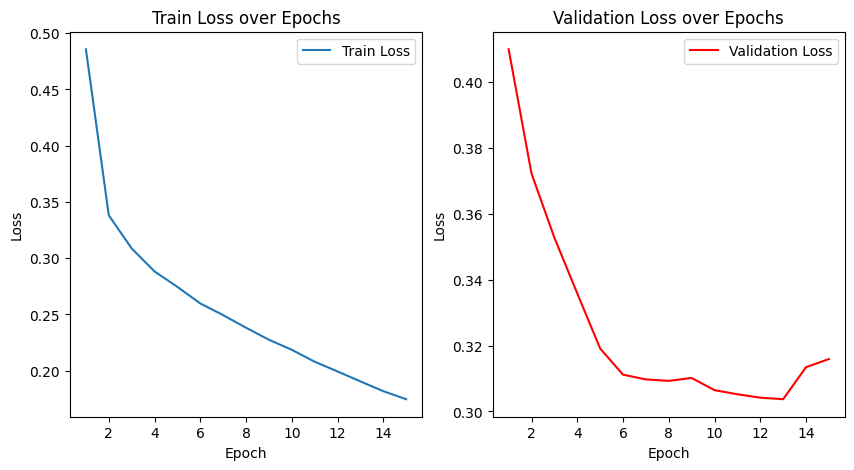

Ошибка на тестовом наборе 0.39



In [13]:
# Инициализируем модель 
model_rnn = NERModel_RNN(input_size=w2v_model.vector_size, hidden_size=128, target_size=len(tag_to_idx))
model_rnn.to(device)

# Определяем оптимизатор и функцию потерь
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)

# Обучение модели
train_validate_model(model_rnn, train_loader, val_loader, optimizer_rnn, criterion, num_epochs=15)

# Тестирование модели
test_model(model_rnn, test_loader, criterion)

Номер эпохи: 1/15, Потери на обучении 0.50
Потери на валидации 0.40

Номер эпохи: 2/15, Потери на обучении 0.34
Потери на валидации 0.36

Номер эпохи: 3/15, Потери на обучении 0.31
Потери на валидации 0.35

Номер эпохи: 4/15, Потери на обучении 0.29
Потери на валидации 0.33

Номер эпохи: 5/15, Потери на обучении 0.27
Потери на валидации 0.31

Номер эпохи: 6/15, Потери на обучении 0.26
Потери на валидации 0.31

Номер эпохи: 7/15, Потери на обучении 0.25
Потери на валидации 0.31

Номер эпохи: 8/15, Потери на обучении 0.23
Потери на валидации 0.30

Номер эпохи: 9/15, Потери на обучении 0.22
Потери на валидации 0.30

Номер эпохи: 10/15, Потери на обучении 0.21
Потери на валидации 0.31

Номер эпохи: 11/15, Потери на обучении 0.20
Потери на валидации 0.31

Номер эпохи: 12/15, Потери на обучении 0.18
Потери на валидации 0.32

Номер эпохи: 13/15, Потери на обучении 0.17
Потери на валидации 0.32

Номер эпохи: 14/15, Потери на обучении 0.16
Потери на валидации 0.32

Номер эпохи: 15/15, Потери на

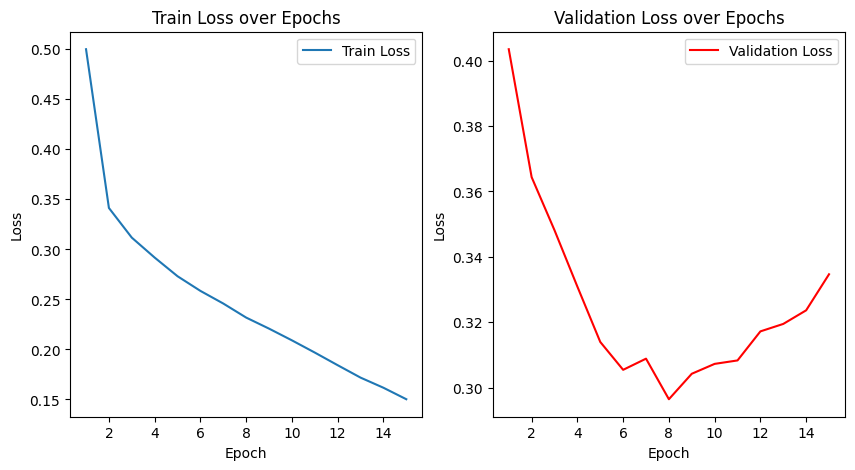

Ошибка на тестовом наборе 0.42



In [19]:
# Инициализируем модель 
model_lstm = NERModel_LSTM(input_size=w2v_model.vector_size,
                           hidden_size=128,
                           target_size=len(tag_to_idx),
                           num_layers=4,
                           bidirectional=True)
model_lstm.to(device)

# Определяем оптимизатор и функцию потерь
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)

# Обучение модели
train_validate_model(model_lstm, train_loader, val_loader, optimizer_lstm, criterion, num_epochs=15)

# Тестирование модели
test_model(model_lstm, test_loader, criterion)

In [14]:
def predict_tags_for_new_sentence(model, sentence, tokenizer, word2vec_model, tag_map, device='cpu'):
    # Токенизация предложения
    tokens = tokenizer(sentence)
    
    # Преобразование токенов в эмбеддинги
    embeddings = []
    for token in tokens:
        # Получаем эмбеддинг для токена, если он есть в модели, иначе используем нулевой вектор
        if token in word2vec_model:
            embeddings.append(word2vec_model[token])
        else:
            embeddings.append(np.zeros(word2vec_model.vector_size))  # Размер эмбеддинга из модели Word2Vec

    # Преобразование списка в numpy массив
    embeddings = np.array(embeddings)

    # Преобразуем эмбеддинги в тензор и отправляем на устройство
    embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32).unsqueeze(0).to(device) 
    
    # Переводим модель на устройство
    model.to(device)
    
    # Прогоняем через модель
    model.eval()  # Включаем режим оценки
    with torch.no_grad():
        outputs = model(embeddings_tensor)  # Выход из модели (непосредственно предсказания)
    
    # Получаем индексы предсказанных тегов
    _, predicted_tags = torch.max(outputs, dim=1)  # Делаем максимизацию по размерности seq_len
    
    # Преобразуем индексы в метки
    predicted_tags = predicted_tags.squeeze().cpu().numpy()  # Убираем лишнюю размерность и переносим в CPU для обработки

    # Преобразуем индексы в метки
    predicted_labels = [tag_map[idx] for idx in predicted_tags]

    return list(zip(tokens, predicted_labels))  # Возвращаем токены с соответствующими тегами

# Пример использования
new_sentence = "John lives in New York."


tag_map = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}
tokenizer = lambda x: x.split()  

# Предсказание
predicted_tags = predict_tags_for_new_sentence(model_rnn.to(device), new_sentence, tokenizer, w2v_model, tag_map)

# Выводим результат
for token, tag in predicted_tags:
    print(f"{token}: {tag}")


John: O
lives: O
in: O
New: B-LOC
York.: I-LOC


In [ ]:
# Пример использования
new_sentence = "John lives in New York"

# Предсказание
predicted_tags = predict_tags_for_new_sentence(model_lstm.to(device), new_sentence, tokenizer, w2v_model, tag_map)

# Выводим результат
for token, tag in predicted_tags:
    print(f"{token}: {tag}")

John: B-PER
lives: O
in: I-ORG
New: O
York: I-ORG
